
# Stock Price Prediction and GameStop Short Squeeze

Prepared by Kateryna Shapovalenko, kshapova@andrew.cmu.edu

**Goal:** To build a stock price prediction model incorporating both historical data and social media sentiment, evaluate its accuracy on the GameStop short squeeze, and analyze potential improvements based on the event.


**Features/targets split**:

- **Features**:
  - Historical Financial data of GameStop (stock prices, trading volume, financial ratios): Yahoo Finance via yfinance or Google Finance
  - Reddit Sentiment Data (Jan-Dec 2021): https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/TUMIPC (`rGME_dataset_features.csv`)
  - Reddit WallStreetBets Posts (Sep 2020 - Oct 2021): https://www.kaggle.com/datasets/gpreda/reddit-wallstreetsbets-posts
  - Sentiment Analysis for Financial News: https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news

- **Targets**: Daily closing stock price.

**Train/test split**:

- **Train**: Before June 2021

- **Test**: June-August 2021

## **Installs**

In [1]:
!pip install yfinance torch torchvision

In [35]:
import pandas as pd
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.dates as mdates
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import datetime, timedelta
from collections import Counter
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



## **Part 1: Model Building**

### **1.1 Data Acquisition**

In [4]:
# Historical Financial data of GameStop (from Yahoo Finance)
tickerSymbol = 'GME' # Define the ticker symbol
tickerData = yf.Ticker(tickerSymbol) # Get data on this ticker
stock_prices_df = tickerData.history(period='1d', start='2021-01-04', end='2021-12-31') # 2021-08-31
columns = stock_prices_df.columns.tolist()
close_index = columns.index('Close')
columns = [columns[close_index]] + columns[:close_index] + columns[close_index + 1:] # make sure 'Close' is the first column
stock_prices_df = stock_prices_df[columns]
stock_prices_df.head(3)

,Close,Open,High,Low,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-04 00:00:00-05:00,4.3125,4.7500,4.775,4.2875,40090000,0.0,0.0
2021-01-05 00:00:00-05:00,4.3425,4.3375,4.520,4.3075,19846000,0.0,0.0
2021-01-06 00:00:00-05:00,4.5900,4.3350,4.745,4.3325,24224800,0.0,0.0


In [5]:
# Reddit Sentiment Data (from Harvard)
path = 'drive/MyDrive/94812 - NLX and LLM/rGME_dataset_features.csv'
reddit_harvard_df = pd.read_csv(path)
reddit_harvard_df.head(3)

<ipython-input-5-7837144d3b1a>:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  reddit_harvard_df = pd.read_csv(path)


,Unnamed: 0,id,title,url,score,author,num_comments,date,flair,compound,...,_poss,_intj,_appos,_npadvmod,_predet,_case,_expl,_oprd,_dative,_nmod
0,0,kqfajb,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,https://www.reddit.com/r/GME/comments/kqfajb/y...,1.0,TitsDownOnly,9.0,2021-01-04,NaN,0.9872,...,0,0,6,0,0,0,0,0,0,0
1,1,kqjh2t,Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀,/r/wallstreetbets/comments/kqcwdo/gamestops_gr...,1.0,zoomermoney,1.0,2021-01-04,NaN,0.9906,...,0,0,3,0,0,0,0,0,0,0
2,2,kqvp7l,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,https://www.reddit.com/r/GME/comments/kqvp7l/t...,1.0,TitsDownOnly,6.0,2021-01-05,NaN,0.5319,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Reddit WallStreetBets Posts (from Kaggle)
"""
path = 'drive/MyDrive/94812-NLX-and-LLM/reddit_wsb.csv'
reddit_kaggle_df = pd.read_csv(path)
reddit_kaggle_df.head(3)
"""

In [ ]:
# Sentiment Analysis for Financial News (from Kaggle)
"""
path = 'drive/MyDrive/94812-NLX-and-LLM/all-data.csv'
column_names = ['Sentiment', 'News']
sentiment_kaggle_df = pd.read_csv(path, encoding='ISO-8859-1', names=column_names)
sentiment_kaggle_df.head(3)
"""

### **1.2 Feature Engineering**


#### **Financial data**

In [6]:
# Checking the missing values
missing_values = stock_prices_df.isnull().sum()
missing_values

Close           0
Open            0
High            0
Low             0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [ ]:
# See the section 2.3 Model Building --> Time-series forecasting model (financial data)

#### **Reddit data**

In [7]:
# The data is already pre-processed and includes the sentiment scores
# We keep 'compound', 'neg', 'neu', and 'pos' columns
reddit_harvard_df['date'] = pd.to_datetime(reddit_harvard_df['date'])
sentiment_aggregated = reddit_harvard_df.groupby('date').agg({'compound': 'mean', 'neg': 'mean', 'neu': 'mean', 'pos': 'mean'}).reset_index()
sentiment_aggregated.head(3)

,date,compound,neg,neu,pos
0,2021-01-04,0.98890,0.0000,0.1340,0.8660
1,2021-01-05,0.11795,0.0575,0.8145,0.1280
2,2021-01-06,0.38885,0.0535,0.7580,0.1885


In [8]:
# Checking the missing values
missing_values = sentiment_aggregated.isnull().sum()
missing_values

date        0
compound    0
neg         0
neu         0
pos         0
dtype: int64

#### **Combined data**

In [ ]:
# See the section 2.3 Model Building --> Model fusion (combined data)

### **1.3 Model Building**


#### **Time-series forecasting model (financial data)**

In [9]:
# Splitting the data into train/val/test

# Config
dataNum = 5
timesteps = 20
epochNum = 20

# Train -----------------------------------------------------------------------
dataset_train = stock_prices_df[stock_prices_df.index < '2021-06-01']
print(dataset_train.shape)
training_set = dataset_train.iloc[:,1:dataNum+1].values
print(training_set.shape)

### Feature scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
print(training_set_scaled.shape)

### Splitting into inputs/targets
X_train = []
Y_train = []
for i in range(timesteps, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-timesteps:i, 0:dataNum])
    Y_train.append(training_set_scaled[i, 0])
X_train, Y_train = np.array(X_train), np.array(Y_train)
print(X_train.shape, Y_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], dataNum))
print(X_train.shape, Y_train.shape)

# Val -----------------------------------------------------------------------
val_df = stock_prices_df[(stock_prices_df.index >= '2021-09-01') & (stock_prices_df.index <= '2021-12-31')]
validation_set = val_df.iloc[:, 1:dataNum+1].values

### Feature scaling
validation_set_scaled = sc.transform(validation_set)

### Splitting into inputs/targets
X_val = []
Y_val = []
for i in range(timesteps, len(validation_set_scaled)):
    X_val.append(validation_set_scaled[i-timesteps:i, 0:dataNum])
    Y_val.append(validation_set_scaled[i, 0])
X_val, Y_val = np.array(X_val), np.array(Y_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], dataNum))

# Test  -----------------------------------------------------------------------
test_set = stock_prices_df[(stock_prices_df.index >= '2021-06-01') & (stock_prices_df.index < '2021-09-01')]
print(test_set.shape)
real_stock_price = test_set.iloc[:,1:dataNum+1].values
print(real_stock_price.shape)
lenOfReal = len(real_stock_price)
inputs = real_stock_price
inputs = sc.transform(inputs)
print(inputs.shape)

# Combine the last 20 days of training data with the test data
last_20_days_training = training_set_scaled[-timesteps:]
print('last_20_days_training', last_20_days_training.shape)
combined_test_data = np.concatenate((last_20_days_training, inputs))
print('inputs', inputs.shape)
print('combined_test_data', combined_test_data.shape)
# Now create inputs_test using the combined data
inputs_test = []
for i in range(timesteps, len(inputs) + timesteps):  # Adjust the range
    inputs_test.append(combined_test_data[i-timesteps:i, 0:dataNum])
inputs_test = np.array(inputs_test)
inputs_test = np.reshape(inputs_test, (inputs_test.shape[0], inputs_test.shape[1], dataNum))
print('inputs_test', inputs_test.shape)

(102, 7)
(102, 5)
(102, 5)
(82, 20, 5) (82,)
(82, 20, 5) (82,)
(65, 7)
(65, 5)
(65, 5)
last_20_days_training (20, 5)
inputs (65, 5)
combined_test_data (85, 5)
inputs_test (65, 20, 5)


In [47]:
# Define the model
model = Sequential()
model.add(LSTM(units=500, input_shape=(X_train.shape[1], dataNum), return_sequences=True))
model.add(LSTM(units=400))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
model.summary()

# Train the model and save the history
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=32, epochs=epochNum)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 20, 500)           1012000   
                                                                 
 lstm_9 (LSTM)               (None, 400)               1441600   
                                                                 
 dense_4 (Dense)             (None, 1)                 401       
                                                                 
Total params: 2454001 (9.36 MB)
Trainable params: 2454001 (9.36 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
3/3 [==============================] - 10s 1s/step - loss: 0.1029 - mean_squared_error: 0.1029 - val_loss: 0.0444 - val_mean_squared_error: 0.0444
Epoch 2/20
3/3 [==============================] - 1s 457ms/step - loss: 0.0446 - mean_squared_error: 0.0446 - val_loss: 0.

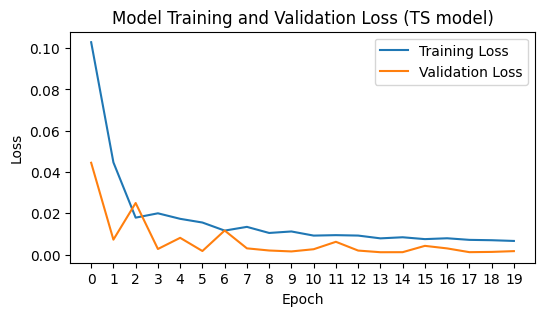

"\nplt.figure(figsize=(6, 2))\nplt.plot(history.history['mean_squared_error'], label='Training MSE')\nplt.plot(history.history['val_mean_squared_error'], label='Validation MSE')\nplt.title('Model Training and Validation MSE (TS model)')\nplt.ylabel('MSE')\nplt.xlabel('Epoch')\nplt.xticks(epoch_range)\nplt.legend()\nplt.show()\n"

In [50]:
# Plot the training and validation loss
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss (TS model)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
epoch_range = range(0, epochNum)
plt.xticks(epoch_range)
plt.legend()
plt.show()

# Plot the training and validation MSE
"""
plt.figure(figsize=(6, 2))
plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.title('Model Training and Validation MSE (TS model)')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.xticks(epoch_range)
plt.legend()
plt.show()
"""

3/3 [==============================] - 1s 88ms/step


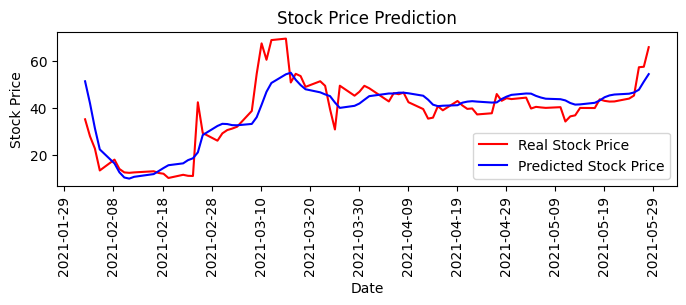

<Figure size 640x480 with 0 Axes>

In [51]:
# Predict on train ------------------------------------------------------------

## real
real_train = dataset_train
real_train = dataset_train.iloc[timesteps:len(real_train)+1,1:2].values
train_dates = dataset_train.index.to_list()
adjusted_train_dates = train_dates[timesteps:len(real_train) + timesteps]

## predicted
predicted_train = model.predict(X_train)
predicted_train = np.pad(predicted_train,((0,0),(0,dataNum-1)),'constant')
predicted_train = sc.inverse_transform(predicted_train)
predicted_train = np.delete(predicted_train, [1, 2, 3, 4], axis=1)
np.savetxt('GME_pred_train' + '.csv', predicted_train, fmt="%.3f", delimiter=",")

## chart
plt.figure(figsize=(8, 2))
plt.plot(adjusted_train_dates, real_train, color = 'red', label = 'Real Stock Price')
plt.plot(adjusted_train_dates, predicted_train, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.show()
plt.savefig('pic1.png')

In [52]:
train_df = pd.DataFrame({
    'Date': pd.to_datetime(adjusted_train_dates).date,
    'Real_Price_Train': real_train.flatten(),
    'Predicted_Price_Train': predicted_train.flatten()})
train_df.tail()

,Date,Real_Price_Train,Predicted_Price_Train
77,2021-05-24,43.962502,46.030331
78,2021-05-25,45.250000,46.551838
79,2021-05-26,57.250000,47.724651
80,2021-05-27,57.450001,51.138783
81,2021-05-28,65.742500,54.335972


test_set (65, 7)
real_test (65, 1)
test_dates (65,)
inputs_test (65, 20, 5)
3/3 [==============================] - 0s 71ms/step
predicted_test (65, 1)
(65, 20, 5)
(65, 20, 5)


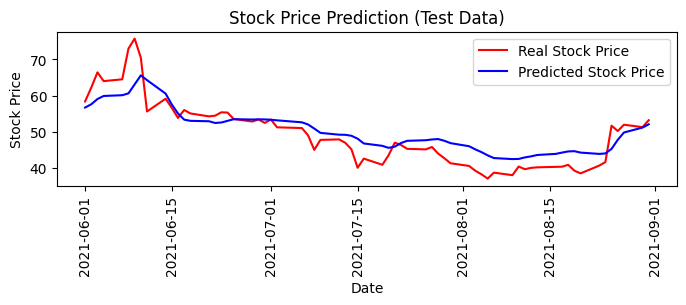

<Figure size 640x480 with 0 Axes>

In [53]:
# Predict on test ------------------------------------------------------------

## real
print('test_set', test_set.shape)
real_test = test_set.iloc[0:lenOfReal+1,1:2].values # test_set.iloc[timesteps:lenOfReal+1,1:2].values
print('real_test', real_test.shape)
test_dates = test_set.index[0:lenOfReal+1] # test_set.index[timesteps:lenOfReal+1]
print('test_dates', test_dates.shape)

## predicted
print('inputs_test', inputs_test.shape)
predicted_test = model.predict(inputs_test)
print('predicted_test', predicted_test.shape)
predicted_test = np.pad(predicted_test,((0,0),(0,dataNum-1)),'constant')
predicted_test = sc.inverse_transform(predicted_test)
predicted_test = np.delete(predicted_test, [1, 2, 3, 4], axis=1)
print(inputs_test.shape)
predicted_test = predicted_test[:len(test_dates)] # NEW
print(inputs_test.shape)
np.savetxt('GME_pred_test' + '.csv', predicted_test, fmt="%.3f", delimiter=",")

## chart
plt.figure(figsize=(8, 2))
plt.plot(test_dates, real_test, color = 'red', label = 'Real Stock Price')
plt.plot(test_dates, predicted_test, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction (Test Data)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=90)
plt.legend()
plt.show()
plt.savefig('pic2.png')

In [54]:
test_df = pd.DataFrame({
    'Date': pd.to_datetime(test_dates).date,
    'Real_Price_Test': real_test.flatten(),
    'Predicted_Price_Test': predicted_test.flatten()})
test_df.head()

,Date,Real_Price_Test,Predicted_Price_Test
0,2021-06-01,58.369999,56.672958
1,2021-06-02,62.220001,57.592758
2,2021-06-03,66.427498,59.041401
3,2021-06-04,64.004997,59.889492
4,2021-06-07,64.500000,60.096260


In [55]:
# Key stats

## train
print('train_dates', len(train_dates))
print('adjusted_train_dates', len(adjusted_train_dates))
print('real_train', len(real_train))
print('predicted_train', len(predicted_train))

## test
print('\ntest_dates', len(test_dates))
print('real_test', len(real_test))
# print('predicted_test', len(predicted_test))

train_dates 102
adjusted_train_dates 82
real_train 82
predicted_train 82

test_dates 65
real_test 65


In [63]:
# Evaluation metrics

# train
mseTrain = round(mean_squared_error(real_train, predicted_train), 2)
rmseTrain = round(math.sqrt(mseTrain), 2)
maeTrain = round(mean_absolute_error(real_train, predicted_train), 2)

print("Training Data Metrics:")
print("MSE_train = " + str(mseTrain))
print("RMSE_train = " + str(rmseTrain))
print("MAE_train = " + str(maeTrain))

# test
mseTest = round(mean_squared_error(real_test, predicted_test), 2)
rmseTest = round(math.sqrt(mseTest), 2)
maeTest = round(mean_absolute_error(real_test, predicted_test), 2)

print("\nTesting Data Metrics:")
print("MSE_test = " + str(mseTest))
print("RMSE_test = " + str(rmseTest))
print("MAE_test = " + str(maeTest))

Training Data Metrics:
MSE_train = 52.24
RMSE_train = 7.23
MAE_train = 5.18

Testing Data Metrics:
MSE_test = 18.97
RMSE_test = 4.36
MAE_test = 3.51


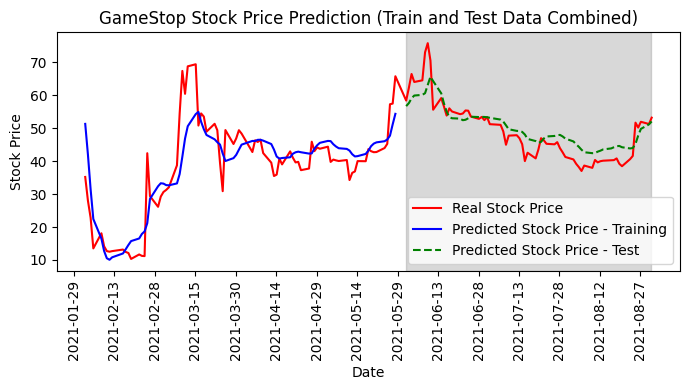

<Figure size 640x480 with 0 Axes>

In [64]:
# Combined chart

combined_dates = np.concatenate((adjusted_train_dates, test_dates)) # Combine the dates
combined_real = np.concatenate((real_train, real_test)) # Combine the real prices
combined_predicted = np.concatenate((predicted_train, predicted_test)) # Combine the predicted prices

# Create the chart
plt.figure(figsize=(7, 4))
plt.plot(combined_dates, combined_real, color='red', label='Real Stock Price') # Plot the real stock prices
plt.plot(adjusted_train_dates, predicted_train, color='blue', label='Predicted Stock Price - Training') # Plot the predicted stock prices - training period
plt.plot(test_dates, predicted_test, color='green', linestyle='dashed', label='Predicted Stock Price - Test') # Plot the predicted stock prices - test (predicted) period
plt.title('GameStop Stock Price Prediction (Train and Test Data Combined)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

start_date = pd.to_datetime('2021-06-01')
end_date = pd.to_datetime('2021-08-31')
plt.axvspan(start_date, end_date, color='grey', alpha=0.3)

plt.xticks(rotation=90)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.tight_layout()
plt.show()
plt.savefig('pic3.png')

#### **Sentiment analysis model**

In [ ]:
# No need to do this. The Harvard dataset already includes sentiment scores.

#### **Model fusion (combined data)**

In [12]:
# Prepare financial data for merging with the sentiment data
stock_prices_df2 = stock_prices_df[['Close', 'Open', 'High', 'Low', 'Volume']].copy()
stock_prices_df2.reset_index(inplace=True)
stock_prices_df2.rename(columns={'Date': 'date'}, inplace=True)
stock_prices_df2['date'] = stock_prices_df2['date'].dt.tz_localize(None)
stock_prices_df2['date'] = stock_prices_df2['date'].dt.strftime('%Y-%m-%d')
stock_prices_df2['date'] = pd.to_datetime(stock_prices_df2['date'])
stock_prices_df2.head(3)

,date,Close,Open,High,Low,Volume
0,2021-01-04,4.3125,4.7500,4.775,4.2875,40090000
1,2021-01-05,4.3425,4.3375,4.520,4.3075,19846000
2,2021-01-06,4.5900,4.3350,4.745,4.3325,24224800


In [13]:
# Merge financial data with the sentiment data
combined_df = stock_prices_df2.merge(sentiment_aggregated, on='date', how='left')
combined_df.fillna(method='ffill', inplace=True)
combined_df.set_index('date', inplace=True)
print(combined_df.shape)
combined_df.head(3)

(251, 9)


,Close,Open,High,Low,Volume,compound,neg,neu,pos
date,,,,,,,,,
2021-01-04,4.3125,4.7500,4.775,4.2875,40090000,0.98890,0.0000,0.1340,0.8660
2021-01-05,4.3425,4.3375,4.520,4.3075,19846000,0.11795,0.0575,0.8145,0.1280
2021-01-06,4.5900,4.3350,4.745,4.3325,24224800,0.38885,0.0535,0.7580,0.1885


In [14]:
combined_df.columns

Index(['Close', 'Open', 'High', 'Low', 'Volume', 'compound', 'neg', 'neu',
       'pos'],
      dtype='object')

In [52]:
# Splitting the data into train/val/test

# Config
dataNum = 8
timesteps = 10
epochNum = 300

# Train -----------------------------------------------------------------------
dataset_train = combined_df[combined_df.index < '2021-06-01']
print(dataset_train.shape)
training_set = dataset_train.iloc[:,1:dataNum+1].values
print(training_set.shape)

### Feature scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
print(training_set_scaled.shape)

### Splitting into inputs/targets
X_train = []
Y_train = []
for i in range(timesteps, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-timesteps:i, 0:dataNum])
    Y_train.append(training_set_scaled[i, 0])
X_train, Y_train = np.array(X_train), np.array(Y_train)
print(X_train.shape, Y_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], dataNum))
print(X_train.shape, Y_train.shape)

# Val -----------------------------------------------------------------------
val_df = combined_df[(combined_df.index >= '2021-09-01') & (combined_df.index <= '2021-12-31')]
validation_set = val_df.iloc[:, 1:dataNum+1].values

### Feature scaling
validation_set_scaled = sc.transform(validation_set)

### Splitting into inputs/targets
X_val = []
Y_val = []
for i in range(timesteps, len(validation_set_scaled)):
    X_val.append(validation_set_scaled[i-timesteps:i, 0:dataNum])
    Y_val.append(validation_set_scaled[i, 0])
X_val, Y_val = np.array(X_val), np.array(Y_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], dataNum))

# Test  -----------------------------------------------------------------------
test_set = combined_df[(combined_df.index >= '2021-06-01') & (combined_df.index < '2021-09-01')]
print(test_set.shape)
real_stock_price = test_set.iloc[:,1:dataNum+1].values
print(real_stock_price.shape)
lenOfReal = len(real_stock_price)
inputs = real_stock_price
inputs = sc.transform(inputs)
print(inputs.shape)

# Combine the last 20 days of training data with the test data
last_20_days_training = training_set_scaled[-timesteps:]
print('last_20_days_training', last_20_days_training.shape)
combined_test_data = np.concatenate((last_20_days_training, inputs))
print('inputs', inputs.shape)
print('combined_test_data', combined_test_data.shape)
# Now create inputs_test using the combined data
inputs_test = []
for i in range(timesteps, len(inputs) + timesteps):  # Adjust the range
    inputs_test.append(combined_test_data[i-timesteps:i, 0:dataNum])
inputs_test = np.array(inputs_test)
inputs_test = np.reshape(inputs_test, (inputs_test.shape[0], inputs_test.shape[1], dataNum))
print('inputs_test', inputs_test.shape)

(102, 9)
(102, 8)
(102, 8)
(92, 10, 8) (92,)
(92, 10, 8) (92,)
(65, 9)
(65, 8)
(65, 8)
last_20_days_training (10, 8)
inputs (65, 8)
combined_test_data (75, 8)
inputs_test (65, 10, 8)


In [53]:
# Define the model
model_combined = Sequential()

#model_combined.add(Bidirectional(LSTM(units=1000, return_sequences=True), input_shape=(X_train.shape[1], dataNum)))
#model_combined.add(Bidirectional(LSTM(units=500)))

model_combined.add(LSTM(units=800, input_shape=(X_train.shape[1], dataNum), return_sequences=True))
model_combined.add(Dropout(0.05))
model_combined.add(LSTM(units=700))

model_combined.add(Dense(units=1))
model_combined.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
model_combined.summary()

# Train the model and save the history
history_combined = model_combined.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=20, epochs=epochNum)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 10, 800)           2588800   
                                                                 
 dropout_1 (Dropout)         (None, 10, 800)           0         
                                                                 
 lstm_9 (LSTM)               (None, 700)               4202800   
                                                                 
 dense_4 (Dense)             (None, 1)                 701       
                                                                 
Total params: 6792301 (25.91 MB)
Trainable params: 6792301 (25.91 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
5/5 [==============================] - 4s 194ms/step - loss: 0.2234 - mean_squared_error: 0.2234 - val_loss: 0.0983 - val_mean_squared

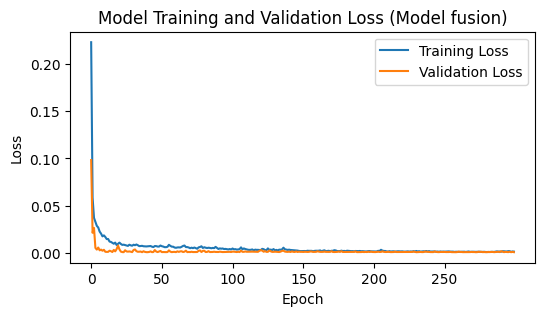

"\nplt.figure(figsize=(6, 2))\nplt.plot(history_combined.history_combined['mean_squared_error'], label='Training MSE')\nplt.plot(history_combined.history_combined['val_mean_squared_error'], label='Validation MSE')\nplt.title('Model Training and Validation MSE (TS model)')\nplt.ylabel('MSE')\nplt.xlabel('Epoch')\nplt.xticks(epoch_range)\nplt.legend()\nplt.show()\n"

In [54]:
# Plot the training and validation loss
plt.figure(figsize=(6, 3))
plt.plot(history_combined.history['loss'], label='Training Loss')
plt.plot(history_combined.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss (Model fusion)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
epoch_range = range(0, epochNum, 50)
plt.xticks(epoch_range)
plt.legend()
plt.show()

# Plot the training and validation MSE
"""
plt.figure(figsize=(6, 2))
plt.plot(history_combined.history_combined['mean_squared_error'], label='Training MSE')
plt.plot(history_combined.history_combined['val_mean_squared_error'], label='Validation MSE')
plt.title('Model Training and Validation MSE (TS model)')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.xticks(epoch_range)
plt.legend()
plt.show()
"""


## **Part 2: Retrospective Predictions and Evaluation**

### **2.1 Prediction Period**


3/3 [==============================] - 1s 5ms/step


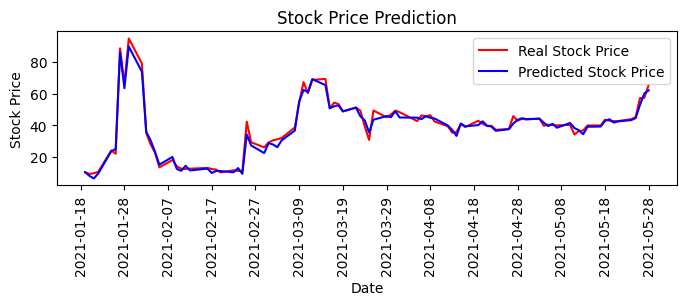

<Figure size 640x480 with 0 Axes>

In [55]:
# Predict on train ------------------------------------------------------------

## real
real_train = dataset_train
real_train = dataset_train.iloc[timesteps:len(real_train)+1,1:2].values
train_dates = dataset_train.index.to_list()
adjusted_train_dates = train_dates[timesteps:len(real_train) + timesteps]

## predicted
predicted_train = model_combined.predict(X_train)
dummy_array = np.zeros((predicted_train.shape[0], training_set_scaled.shape[1]))
dummy_array[:, 0] = predicted_train.flatten()
predicted_train = sc.inverse_transform(dummy_array)[:, 0]
predicted_train= predicted_train.reshape(-1, 1)
np.savetxt('GME_pred_train' + '.csv', predicted_train, fmt="%.3f", delimiter=",")

## chart
plt.figure(figsize=(8, 2))
plt.plot(adjusted_train_dates, real_train, color = 'red', label = 'Real Stock Price')
plt.plot(adjusted_train_dates, predicted_train, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.show()
plt.savefig('pic1.png')

In [56]:
train_df = pd.DataFrame({
    'Date': pd.to_datetime(adjusted_train_dates).date,
    'Real_Price_Train': real_train.flatten(),
    'Predicted_Price_Train': predicted_train.flatten()})
train_df.tail()

,Date,Real_Price_Train,Predicted_Price_Train
87,2021-05-24,43.962502,43.359804
88,2021-05-25,45.250000,44.639379
89,2021-05-26,57.250000,52.972226
90,2021-05-27,57.450001,60.209295
91,2021-05-28,65.742500,62.180829


3/3 [==============================] - 0s 6ms/step


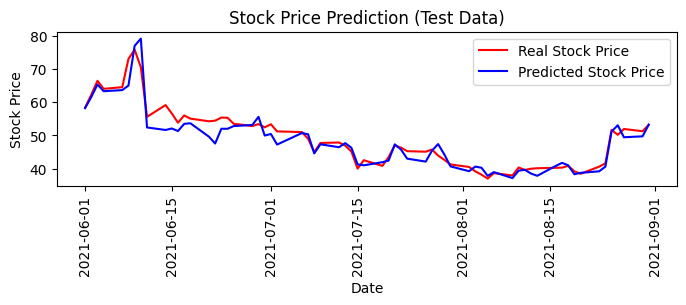

<Figure size 640x480 with 0 Axes>

In [57]:
# Predict on test ------------------------------------------------------------

## real
real_test = test_set.iloc[0:lenOfReal+1,1:2].values
test_dates = test_set.index[0:lenOfReal+1]

## predicted
predicted_test = model_combined.predict(inputs_test)
dummy_array = np.zeros((predicted_test.shape[0], training_set_scaled.shape[1]))
dummy_array[:, 0] = predicted_test.flatten()
predicted_test = sc.inverse_transform(dummy_array)[:, 0]
predicted_test = predicted_test.reshape(-1, 1)
np.savetxt('GME_pred_test' + '.csv', predicted_test, fmt="%.3f", delimiter=",")

## chart
plt.figure(figsize=(8, 2))
plt.plot(test_dates, real_test, color = 'red', label = 'Real Stock Price')
plt.plot(test_dates, predicted_test, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction (Test Data)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=90)
plt.legend()
plt.show()
plt.savefig('pic2.png')

In [58]:
test_df = pd.DataFrame({
    'Date': pd.to_datetime(test_dates).date,
    'Real_Price_Test': real_test.flatten(),
    'Predicted_Price_Test': predicted_test.flatten()})
test_df.head()

,Date,Real_Price_Test,Predicted_Price_Test
0,2021-06-01,58.369999,58.194147
1,2021-06-02,62.220001,61.548990
2,2021-06-03,66.427498,65.309899
3,2021-06-04,64.004997,63.290113
4,2021-06-07,64.500000,63.622796


### **2.2 Evaluation**
- Comparison with actual prices.
- Calculation of MSE, RMSE, and MAE.


In [59]:
# Evaluation metrics

# train
mseTrain = round(mean_squared_error(real_train, predicted_train), 2)
rmseTrain = round(math.sqrt(mseTrain), 2)
maeTrain = round(mean_absolute_error(real_train, predicted_train), 2)

print("Training Data Metrics:")
print("MSE_train = " + str(mseTrain))
print("RMSE_train = " + str(rmseTrain))
print("MAE_train = " + str(maeTrain))

# test
mseTest = round(mean_squared_error(real_test, predicted_test), 2)
rmseTest = round(math.sqrt(mseTest), 2)
maeTest = round(mean_absolute_error(real_test, predicted_test), 2)

print("\nTesting Data Metrics:")
print("MSE_test = " + str(mseTest))
print("RMSE_test = " + str(rmseTest))
print("MAE_test = " + str(maeTest))

Training Data Metrics:
MSE_train = 5.72
RMSE_train = 2.39
MAE_train = 1.8

Testing Data Metrics:
MSE_test = 6.98
RMSE_test = 2.64
MAE_test = 1.87



### **2.3 Visualization** (visualizing the discrepancies)

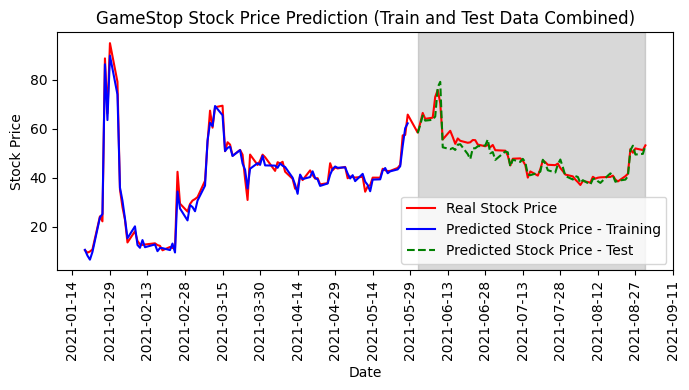

<Figure size 640x480 with 0 Axes>

In [66]:
# Combined chart

adjusted_train_dates = pd.to_datetime(adjusted_train_dates)
test_dates = pd.to_datetime(test_dates)

combined_dates = np.concatenate((adjusted_train_dates, test_dates)) # Combine the dates
combined_real = np.concatenate((real_train, real_test)) # Combine the real prices
combined_predicted = np.concatenate((predicted_train, predicted_test)) # Combine the predicted prices

# Create the chart
plt.figure(figsize=(7, 4))
plt.plot(combined_dates, combined_real, color='red', label='Real Stock Price') # Plot the real stock prices
plt.plot(adjusted_train_dates, predicted_train, color='blue', label='Predicted Stock Price - Training') # Plot the predicted stock prices - training period
plt.plot(test_dates, predicted_test, color='green', linestyle='dashed', label='Predicted Stock Price - Test') # Plot the predicted stock prices - test (predicted) period
plt.title('GameStop Stock Price Prediction (Train and Test Data Combined)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

start_date = pd.to_datetime('2021-06-01')
end_date = pd.to_datetime('2021-08-31')
plt.axvspan(start_date, end_date, color='grey', alpha=0.3)

plt.xticks(rotation=90)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.tight_layout()
plt.show()
plt.savefig('pic3.png')

## **Part 3: GameStop Short Squeeze and Model Adaptation**

### **3.1 Event Analysis**
- Analysis of social media data during the event.


In [83]:
# Convert 'date' column to datetime
reddit_harvard_df['date'] = pd.to_datetime(reddit_harvard_df['date'])
reddit_harvard_df_jan = reddit_harvard_df[(reddit_harvard_df['date'] >= '2021-01-01') & (reddit_harvard_df['date'] <= '2021-01-31')]

# Sentiment Analysis -- Analyze average sentiment scores
avg_sentiment = reddit_harvard_df_jan[['compound', 'neg', 'neu', 'pos']].mean()

# Volume Analysis -- Count the number of posts and comments
volume = reddit_harvard_df_jan[['id', 'num_comments']].count()

# Theme Analysis -- Extract top N most frequent words in post titles
stop_words = set(stopwords.words('english'))

def get_top_n_words(text_series, n=10):
    all_words = ' '.join([text.lower() for text in text_series])
    all_words = word_tokenize(all_words)
    all_words = [word for word in all_words if word.isalpha() and word not in stop_words]
    word_freq = Counter(all_words)
    return word_freq.most_common(n)

top_words = get_top_n_words(reddit_harvard_df_jan['title'])
print("Average Sentiment - Training Period:", avg_sentiment)
print("\nVolume - Training Period:", volume)
print("\nTop Words - Training Period:", top_words)

Average Sentiment - Training Period: compound    0.134468
neg         0.065471
neu         0.788413
pos         0.146116
dtype: float64

Volume - Training Period: id              6947
num_comments    6947
dtype: int64

Top Words - Training Period: [('gme', 1494), ('hold', 977), ('buy', 953), ('sell', 324), ('robinhood', 284), ('stock', 265), ('let', 253), ('get', 246), ('go', 238), ('us', 229)]


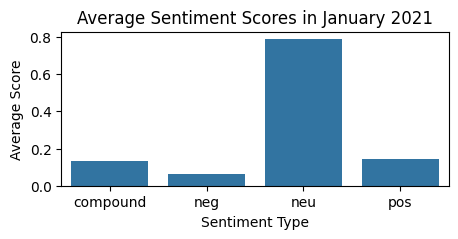

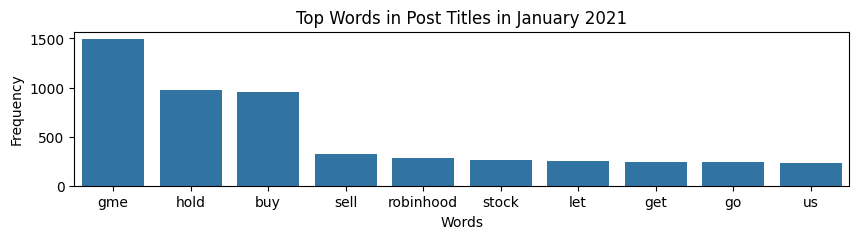

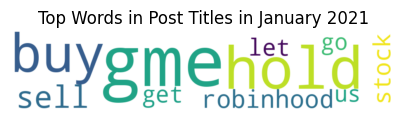

In [82]:
# 1. Sentiment Analysis Visualization
plt.figure(figsize=(5, 2))
sns.barplot(x=avg_sentiment.index, y=avg_sentiment.values)
plt.title('Average Sentiment Scores in January 2021')
plt.ylabel('Average Score')
plt.xlabel('Sentiment Type')
plt.show()

# 2. Volume Analysis Visualization
"""
plt.figure(figsize=(5, 2))
sns.barplot(x=volume.index, y=volume.values)
plt.title('Volume of Posts and Comments in January 2021')
plt.ylabel('Count')
plt.xlabel('Type')
plt.show()
"""

# 3. Top Words Analysis Visualization
top_words_dict = dict(top_words)  # Convert list of tuples to dictionary
plt.figure(figsize=(10, 2))
sns.barplot(x=list(top_words_dict.keys()), y=list(top_words_dict.values()))
plt.title('Top Words in Post Titles in January 2021')
plt.ylabel('Frequency')
plt.xlabel('Words')
plt.xticks(rotation=0)
plt.show()

# 4. Word Cloud for Key Themes
wordcloud = WordCloud(width=1000, height=200, background_color='white').generate_from_frequencies(top_words_dict)
plt.figure(figsize=(5, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Words in Post Titles in January 2021')
plt.show()

In [63]:
# Convert 'date' column to datetime
reddit_harvard_df['date'] = pd.to_datetime(reddit_harvard_df['date'])
reddit_harvard_df_all = reddit_harvard_df[(reddit_harvard_df['date'] >= '2021-01-01') & (reddit_harvard_df['date'] < '2021-09-01')]

# Sentiment Analysis -- Analyze average sentiment scores
avg_sentiment_all = reddit_harvard_df_all[['compound', 'neg', 'neu', 'pos']].mean()

# Volume Analysis -- Count the number of posts and comments
volume_all = reddit_harvard_df_all[['id', 'num_comments']].count()

# Theme Analysis -- Extract top N most frequent words in post titles
stop_words = set(stopwords.words('english'))

def get_top_n_words(text_series, n=10):
    all_words = ' '.join([text.lower() for text in text_series])
    all_words = word_tokenize(all_words)
    all_words = [word for word in all_words if word.isalpha() and word not in stop_words]
    word_freq = Counter(all_words)
    return word_freq.most_common(n)

top_words_all = get_top_n_words(reddit_harvard_df_all['title'])
#print("Average Sentiment - Training Period:", avg_sentiment)
#print("\nVolume - Training Period:", volume)
#print("\nTop Words - Training Period:", top_words)

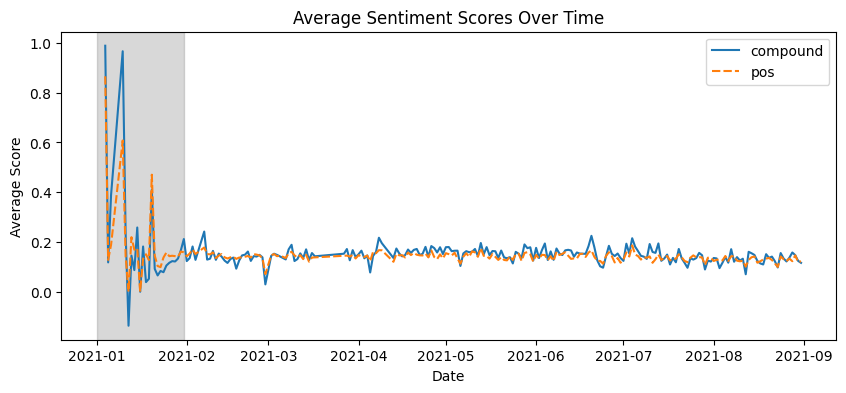

"\nwordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(top_words))\nplt.figure(figsize=(10, 5))\nplt.imshow(wordcloud, interpolation='bilinear')\nplt.axis('off')\nplt.title('Word Cloud of Top Words in Post Titles')\nplt.show()\n"

In [76]:
# 1. Sentiment Over Time
#sentiment_over_time = reddit_harvard_df_all.groupby(reddit_harvard_df_all['date'].dt.date)[['compound', 'neg', 'neu', 'pos']].mean()
sentiment_over_time = reddit_harvard_df_all.groupby(reddit_harvard_df_all['date'].dt.date)[['compound', 'pos']].mean()
plt.figure(figsize=(10, 4))
sns.lineplot(data=sentiment_over_time)
plt.title('Average Sentiment Scores Over Time')
plt.ylabel('Average Score')
plt.xlabel('Date')
start_date = '2021-01-01'
end_date = '2021-01-31'
plt.axvspan(start_date, end_date, color='grey', alpha=0.3)
plt.xticks(rotation=0)
plt.show()

# 2. Volume Over Time
volume_over_time = reddit_harvard_df_all.groupby(reddit_harvard_df_all['date'].dt.date)[['id', 'num_comments']].count()
"""
plt.figure(figsize=(10, 4))
sns.lineplot(data=volume_over_time)
plt.title('Volume of Posts and Comments Over Time')
plt.ylabel('Count')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()
"""

# 3. Word Cloud for Key Themes
"""
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(top_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Top Words in Post Titles')
plt.show()
"""
#

### **3.2 Model Sensitivity**
- Sensitivity analysis.

3/3 [==============================] - 0s 6ms/step


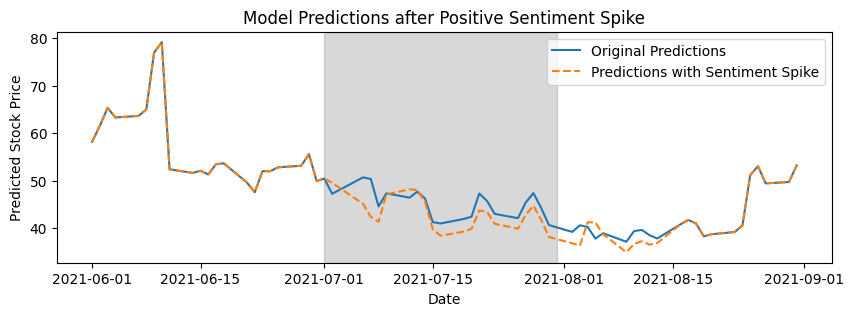

In [75]:
# 1. Create a simulated sentiment spike
start_spike = '2021-07-01'
end_spike = '2021-07-31'
test_set_spike = test_set.copy()

# Apply an artificial spike in sentiment
spike_factor = 0.5  # This is an arbitrary factor to increase the sentiment
test_set_spike.loc[start_spike:end_spike, 'compound'] += spike_factor
test_set_spike['compound'] = test_set_spike['compound'].clip(-1, 1)

# 2. Re-run the model with simulated data
inputs_spike = test_set_spike.iloc[:, 1:dataNum+1].values
inputs_spike = sc.transform(inputs_spike)
combined_test_data_spike = np.concatenate((last_20_days_training, inputs_spike))

inputs_test_spike = []
for i in range(timesteps, len(inputs_spike) + timesteps):
    inputs_test_spike.append(combined_test_data_spike[i-timesteps:i, 0:dataNum])
inputs_test_spike = np.array(inputs_test_spike)
inputs_test_spike = np.reshape(inputs_test_spike, (inputs_test_spike.shape[0], inputs_test_spike.shape[1], dataNum))

# 3. Get predictions
predicted_test_spike = model_combined.predict(inputs_test_spike)
dummy_array = np.zeros((predicted_test_spike.shape[0], training_set_scaled.shape[1]))
dummy_array[:, 0] = predicted_test_spike.flatten()
predicted_test_spike = sc.inverse_transform(dummy_array)[:, 0]
predicted_test_spike = predicted_test_spike.reshape(-1, 1)

# 4. Compare the results
plt.figure(figsize=(10, 3))
plt.plot(test_dates, predicted_test, label='Original Predictions')
plt.plot(test_dates, predicted_test_spike, label='Predictions with Sentiment Spike', linestyle='dashed')
plt.title('Model Predictions after Positive Sentiment Spike')
plt.xlabel('Date')
plt.ylabel('Predicted Stock Price')
plt.legend()
plt.axvspan(start_spike, end_spike, color='grey', alpha=0.3)
plt.xticks(rotation=0)
plt.show()

### **3.3 Algorithmic Adjustments**
- Proposed model adjustments.

In [ ]:
# please see the final report


## **Part 4: Conclusion and Future Directions**
- Summarizing findings and insights.
- Discussing the impact and ethics of social media mining.
- Suggesting future research directions.


In [ ]:
# please see the final report


## **References**
- GameStop: What is it and why is it trending? https://www.bbc.com/news/newsbeat-55841719
- LSTM-based sentiment analysis for stock price forecast: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7959635/
- Reddit Sentiment Data: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/TUMIPC
- Reddit WallStreetBets Posts: https://www.kaggle.com/datasets/gpreda/reddit-wallstreetsbets-posts  
- Sentiment Analysis for Financial News: https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news
- Yahoo Finance (yfinance module in Python): https://pypi.org/project/yfinance/